In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import uuid
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf


2023-07-16 12:15:12.436617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 12:15:13.428346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Defining path
pos_path = os.path.join('data', 'positive')
neg_path = os.path.join('data', 'negative')
anc_path = os.path.join('data', 'anchor')

# Making directory -- Run only once

if os.path.exists(pos_path)==False:
    os.makedirs(pos_path)
if os.path.exists(neg_path)==False:
    os.makedirs(neg_path)
if os.path.exists(anc_path)==False:
    os.makedirs(anc_path)

# Moving my images -- Run only once 
if(os.path.exists('lfw')) == True:
    for directory in os.listdir('lfw'):
        for file in os.listdir(os.path.join('lfw', directory)):
            ex_path = os.path.join('lfw', directory, file)
            new_path = os.path.join(neg_path, file)
            os.replace(ex_path, new_path)


In [3]:
# Gathering data
cap = cv2.VideoCapture(0)

while cap.isOpened():

    ## Get the data
    ret, frame = cap.read()

    ## Cut the frame
    frame = frame[120:120+250, 200:200+250, :]

    ## Show the feed
    cv2.imshow('Image Collection' , frame)

    ## Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        ## Define path
        image_name = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))

        ## Save img
        cv2.imwrite(image_name,frame)
    
    ## Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        ## Define path
        image_name = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))

        ## Save img
        cv2.imwrite(image_name, frame)



    ## Close the window
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [5]:
## Getting image directories

anchor = tf.data.Dataset.list_files(anc_path+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(300)

2023-07-14 22:12:48.645706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 22:12:48.646451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 22:12:48.647064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
x = anchor.as_numpy_iterator()
x.next()

2023-07-14 22:12:48.819330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [398]
	 [[{{node Placeholder/_0}}]]
2023-07-14 22:12:48.819587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [398]
	 [[{{node Placeholder/_0}}]]


b'data/anchor/3daf2e7f-2164-11ee-84c7-536546bb64b4.jpg'

In [7]:
def preprocess(file_path):

    # Read image
    byte_img = tf.io.read_file(file_path)
    # Load image
    img = tf.io.decode_jpeg(byte_img)
    # Resize
    img = tf.image.resize(img, (100,100))
    # Scale
    img = img/255.0

    return img


In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
def preprocess_twin(input, valid, label):
    return (preprocess(input), preprocess(valid), label)

In [10]:
## Data loader pipline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=  1024)

2023-07-14 22:12:48.978246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_30' with dtype string and shape [13233]
	 [[{{node Placeholder/_30}}]]
2023-07-14 22:12:48.978982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype float and shape [300]
	 [[{{node Placeholder/_39}}]]


1.0

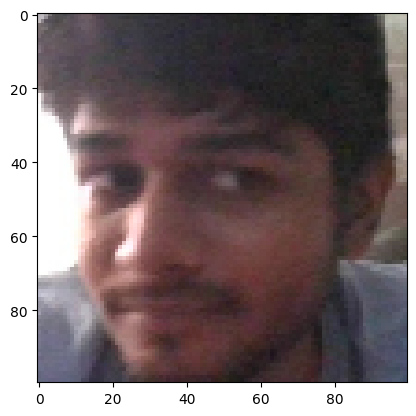

In [11]:
iterator = data.as_numpy_iterator()
sample = iterator.next()
plt.imshow(sample[0])
sample[2]

In [12]:
## Training partition

train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

## Test partition

test_data = data.skip(round(len(data)*0.7))
test_data = data.take(len(data) - round(len(data)*0.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [13]:
## Creating the embedding layers

def make_embedding():
    inp = Input(shape = (100,100,3), name = 'input image')

    # First block
    c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)

    # Fourth block
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)

    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [14]:
embedding = make_embedding()

In [15]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [16]:
## Building the L1 siamese distance layer

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, valid_embedding):
        return tf.math.abs(input_embedding - valid_embedding)

In [17]:
l1 = L1Dist()

In [18]:
## Siamese neural network

def SiameseNN():

    #Loading the images in the network
    input_img = Input(name = 'input_img', shape = (100,100,3))
    valid_img = Input(name = 'validation_img', shape = (100,100,3))

    #Create the l1 siamese dist layer
    siamese_layer = L1Dist()
    siamese_layer._name = 'dist'
    distance = siamese_layer(embedding(input_img), embedding(valid_img))

    classifier = Dense(1, activation = 'sigmoid')(distance) 

    return Model(inputs = [input_img, valid_img], outputs = [classifier], name = 'SiameseNetwork')



In [19]:
siamese_model = SiameseNN()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [20]:
loss_fn = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model )

In [22]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training = True)
        loss = loss_fn(y, yhat)
        print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [23]:
def train(data, epochs):

    for epoch in range(1, epochs+1):
        print('\n Epoch {}/{}'.format(epoch,epochs))
        progbar = tf.keras.utils.Progbar(len(data))

        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)



In [24]:
 epochs = 50
 train(train_data, epochs)


 Epoch 1/50


Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2023-07-14 22:12:49.516475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype string and shape [398]
	 [[{{node Placeholder/_21}}]]
2023-07-14 22:12:49.517116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype float and shape [300]
	 [[{{node Placeholder/_39}}]]


Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2023-07-14 22:12:50.379426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2023-07-14 22:12:50.847359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-14 22:12:50.894868: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd3421d53a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-14 22:12:50.894896: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-14 22:12:50.916349: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-14 22:12:51.132105: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifeti

27/27 [==============================] - 8s 165ms/step

 Epoch 2/50
27/27 [==============================] - 4s 147ms/step

 Epoch 3/50
27/27 [==============================] - 4s 148ms/step

 Epoch 4/50
27/27 [==============================] - 4s 148ms/step

 Epoch 5/50
27/27 [==============================] - 4s 148ms/step

 Epoch 6/50
27/27 [==============================] - 4s 148ms/step

 Epoch 7/50
27/27 [==============================] - 4s 153ms/step

 Epoch 8/50
27/27 [==============================] - 4s 154ms/step

 Epoch 9/50
27/27 [==============================] - 4s 154ms/step

 Epoch 10/50
27/27 [==============================] - 4s 158ms/step

 Epoch 11/50
27/27 [==============================] - 4s 156ms/step

 Epoch 12/50
27/27 [==============================] - 4s 161ms/step

 Epoch 13/50
27/27 [==============================] - 7s 261ms/step

 Epoch 14/50
27/27 [==============================] - 4s 157ms/step

 Epoch 15/50
27/27 [==============================] - 4

In [25]:
test_input, test_validation, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_validation])

2023-07-14 22:17:17.738413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype string and shape [398]
	 [[{{node Placeholder/_21}}]]
2023-07-14 22:17:17.738938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype float and shape [300]
	 [[{{node Placeholder/_39}}]]


1/1 [==============================] - 0s 114ms/step


In [26]:
[1 if x>0.5 else 0 for x in y_hat]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]

In [27]:
y_true

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

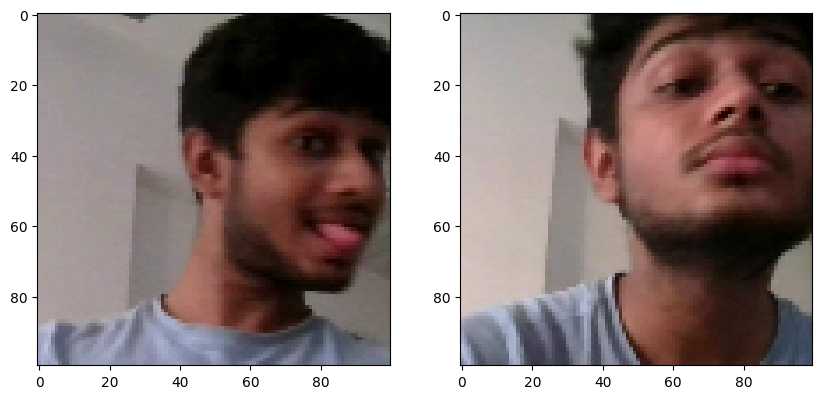

In [28]:
img_index = 8
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(test_input[img_index])

plt.subplot(1,2,2)
plt.imshow(test_validation[img_index])

In [29]:
siamese_model.save('siamesemodel.h5')

In [30]:
 # model = tf.keras.models.load_model('siamesemodel.h5', custom_objects = {'L1Dist':L1Dist})

In [63]:
def verify(model, detection_threshold, verification_threshold):
    results = []

    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        verification_image = preprocess(os.path.join('application_data', 'verification_images', image))

        result = model.predict(list(np.expand_dims([input_img, verification_image], axis = 1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)

    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [68]:
cap = cv2.VideoCapture(0)

while cap.isOpened():

    ret,frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]

    cv2.imshow('Verification', frame)

    if cv2.waitKey(10) & 0XFF == ord('q'):
        break
    if cv2.waitKey(10) & 0XFF == ord('v'):
        cv2.imwrite(os.path.join('application_data' , 'input_image', 'input_image.jpg'), frame)
        results,verified = verify(siamese_model, 0.8, 0.6)
        print(verified)

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step
False
1/1 [==============================] - 0s 15ms/step
True
